# Experiment E

Ideas:

1) Implementar formas de processar o dataset

1.1) Implementar o baseline com escala de acordo com a variância dos dados, missing values score and entropy.

1.2) Implementar o SVD.

1.3) Ver como implementar as decomposições em `sklearn.decomposition`.

2) Implementar outras distâncias

- Author: Israel Oliveira [\[e-mail\]](mailto:'Israel%20Oliveira%20'<prof.israel@gmail.com>)

In [1]:
%load_ext watermark

In [2]:
from typing import NewType, List
from loguru import logger
import pandas as pd
import numpy as np
import jax.numpy as npj
from jax import jit
from time import time
from scipy.spatial.distance import cosine
from sklearn.decomposition import FactorAnalysis, DictionaryLearning, FastICA, PCA, IncrementalPCA, KernelPCA, LatentDirichletAllocation, NMF, SparsePCA, TruncatedSVD
from collections import defaultdict, Counter
import functools
import operator
from copy import deepcopy

In [3]:
# Run this cell before close.
%watermark
%watermark -p loguru
%watermark -p jax
%watermark -p sklearn
%watermark --iversion
%watermark -b -r -g

2020-07-05T03:26:36+00:00

CPython 3.7.7
IPython 7.16.1

compiler   : GCC 8.3.0
system     : Linux
release    : 5.4.0-7634-generic
machine    : x86_64
processor  : 
CPU cores  : 8
interpreter: 64bit
loguru 0.5.1
jax 0.1.72
sklearn 0.23.1
numpy  1.19.0
pandas 1.0.5

Git hash: 020136c9d00459366895fa09dee8bd7680b5d7a9
Git repo: https://github.com/ysraell/aceleradev_private.git
Git branch: master


Para fazer o item 1, creio que nesse momento eu preciso de ter alguma forma de ordenar as colunas de acordo com algum critério.
a) Pela quantidade de missing values já é um bom começo. Talvez o total de missing dividido pela quantidade de valores únicos.

In [4]:
logger.info("Carregando dataset...")

path_data = '../data/'
df_marked = pd.read_csv(path_data+'estaticos_market.csv')
df_marked = df_marked.drop(columns=['Unnamed: 0'])
logger.info("...pronto!")

logger.info("Carregando dataset de validação...")

df_ep_list = [pd.read_csv(path_data+'estaticos_portfolio{}.csv'.format(i+1)) for i in range(3)]
tmp = []
for i in range(3):
    df_ep_list[i]['P'] = i+1 
    tmp.append(df_ep_list[i][['id','P']])
df_ep = pd.concat(tmp)
del df_ep_list
del tmp
logger.info("...pronto!")

2020-07-05 03:26:37.413 | INFO     | __main__:<module>:1 - Carregando dataset...
2020-07-05 03:26:43.798 | INFO     | __main__:<module>:6 - ...pronto!
2020-07-05 03:26:43.799 | INFO     | __main__:<module>:8 - Carregando dataset de validação...
2020-07-05 03:26:43.829 | INFO     | __main__:<module>:18 - ...pronto!


In [5]:
def feat_proc(dataset = df_marked, col_target = 'id', feat_cols = df_marked.columns[2:], N_topcols = -1):
    logger.info("Processando as features...")
    missing_count = {}
    remove_cols = []
    for col in feat_cols:
        try:
            missing_count[col] = sum(dataset[col].isna()) / dataset[col].nunique()
            dataset[col] = dataset[col].fillna(0)*1
        except ZeroDivisionError:
            remove_cols.append(col)

    feat_cols = [col for col in feat_cols if col not in remove_cols]

    def normalize(x):
        return (x-np.min(x))/(np.max(x) - np.min(x)) if (np.max(x) - np.min(x)) > 0 else (x-np.min(x))

    for col in feat_cols:
        try:
            dataset[col] = normalize(dataset[col].tolist())
        except:
            maping = {val:i+1 for i,val in enumerate(dataset[col].unique())}
            dataset[col] = dataset[col].apply(lambda x: maping[x])
            dataset[col] = normalize(dataset[col].tolist())

    remove_cols = []
    for col in feat_cols:
        if df_marked[col].nunique() == 1:
            remove_cols.append(col)
    feat_cols = [col for col in feat_cols if col not in remove_cols]
    N_topcols = N_topcols if (N_topcols > 0) and (N_topcols <= len(feat_cols)) else -1
    feat_cols_vals = [(col,val) for col,val in list(missing_count.items()) if col in feat_cols]
    if N_topcols == -1:
        top_cols = feat_cols
    else:
        top_cols = [col for col,_ in sorted(feat_cols_vals, key=lambda x: x[1])[:N_topcols]]
    
    missing_count = {key:val for key,val in missing_count.items() if col in feat_cols }
    logger.info("...pronto!")
    return dataset[[col_target]+top_cols], missing_count

Funções para cáculo de distâncias e fatorização da matriz do dataset.

In [6]:
def Manhattan(X,vec):
    return abs(X - vec).sum(-1)

def Camberra(X,vec):
    return abs((X - vec)/(X + vec)).sum(-1)

def BrayCurtis(X,vec):
    return abs((X - vec)).sum(-1) / abs((X - vec)).sum(-1).sum(-1)

def np_cossine(X,vec):
    return np.array([sum(X[i]*vec) / sum(X[i]**2)*sum(vec**2) for i in range(X.shape[0])])

def npj_cossine(X,vec):
    return npj.array([sum(X[i]*vec) / sum(X[i]**2)*sum(vec**2) for i in range(X.shape[0])])

def scy_cossine(X,vec):
    return np.array([cosine(X[i],vec) for i in range(X.shape[0])])

Manhattanj = jit(Manhattan)
Camberraj = jit(Camberra)
BrayCurtisj = jit(BrayCurtis)
np_cossinej = jit(npj_cossine)

dist_func = [Manhattan, Camberra, BrayCurtis, np_cossine, scy_cossine]
tmp = [Manhattanj, Camberraj, BrayCurtisj, np_cossinej]

for dist in tmp:
    dist.__name__ += 'j'

dist_func = dist_func+tmp
del tmp

def Nothing(arg):
    return arg

def npSVD(M):
    u, _, _ = np.linalg.svd(M, full_matrices=False)
    return u

def npSVDj(M):
    u, _, _ = npj.linalg.svd(M, full_matrices=False)
    return u

# Mais rápido!
_npSVDj = jit(npSVDj)

def _PCA(M,n_components=None):
    out = PCA(n_components=n_components)
    return out.fit_transform(M)

def _FastICA(M,n_components=None):
    out = FastICA(n_components=n_components)
    return out.fit_transform(M)

def _FactorAnalysis(M,n_components=None):
    out = FactorAnalysis(n_components=n_components)
    return out.fit_transform(M)

def _IncrementalPCA(M,n_components=None):
    out = IncrementalPCA(n_components=n_components)
    return out.fit_transform(M)

def _TruncatedSVD(M,n_components=None):
    out = TruncatedSVD(n_components=n_components)
    return out.fit_transform(M)

def _NMF(M,n_components=None):
    out = NMF(n_components=n_components)
    return out.fit_transform(M)

redux_func = [_NMF, _TruncatedSVD, _IncrementalPCA, _FactorAnalysis, _FastICA, _PCA]

Funções para processar os valores da matriz do dataset.

In [7]:
def escalaropt_missings(df: pd.DataFrame, score: dict):
    df_score = pd.DataFrame(score.items(), columns=['col','score'])
    df_score = pd.DataFrame(missing_count.items(), columns=['col','score'])
    df_score['escala_opt'] = 1-normalize((np.sqrt(df_score.score)))
    #df_score['escala_opt'].sort_values().reset_index(drop=True).plot()
    #df_score['escala_opt'].apply(lambda x: max(x,0.1)).sort_values().reset_index(drop=True).plot()
    df_score['escala_opt'] = df_score['escala_opt'].apply(lambda x: max(x,0.1))
    for row in df_score.iterrows():
        df[row.col] = row.escala_opt*df[row.col]
    return df

def escalaropt_std(df: pd.DataFrame, score: dict):
    df_score = pd.DataFrame(score.items(), columns=['col','score'])
    df_score = pd.DataFrame(missing_count.items(), columns=['col','score'])
    df_score['escala_opt'] = normalize([np.sqrt(np.sqrt(np.sqrt(df[col].std()))) for col in df_score['col']])
    #df_score['escala_opt'].sort_values().reset_index(drop=True).plot()
    #df_score['escala_opt'].apply(lambda x: max(x,0.1)).sort_values().reset_index(drop=True).plot()
    df_score['escala_opt'] = df_score['escala_opt'].apply(lambda x: max(x,0.1))
    for row in df_score.iterrows():
        df[row.col] = row.escala_opt*df[row.col]
    return df

def escalaropt_entropy(df: pd.DataFrame, score: dict):
    df_score = pd.DataFrame(score.items(), columns=['col','score'])
    df_score = pd.DataFrame(missing_count.items(), columns=['col','score'])
    df_score['escala_opt'] = normalize([(-sum((df[col]+1)*np.log(df[col]+1))) for col in df_score['col']])
    #df_score['escala_opt'].sort_values().reset_index(drop=True).plot()
    #df_score['escala_opt'].apply(lambda x: max(x,0.1)).sort_values().reset_index(drop=True).plot()
    df_score['escala_opt'] = df_score['escala_opt'].apply(lambda x: max(x,0.1))
    for row in df_score.iterrows():
        df[row.col] = row.escala_opt*df[row.col]
    return df

procDS_func = [escalaropt_missings, escalaropt_std, escalaropt_entropy]

In [8]:
def flat(a):
    return functools.reduce(operator.iconcat, a, []) 

In [9]:

Uid = NewType('uid', int)
Raw = NewType('raw', str)

class ExMatrix():
    """
        ************
    """
    def __init__(self,stateless: bool = False):
        self.matrix_dict = {}
        self.stateless = stateless
        self.M = None
        self.pu = None
        self.raw = None
        self.uid = None
        self.vector_distance = Manhattan
        self.factorize = Nothing
        self.process_values = Nothing

    def fit(self,dataset: pd.DataFrame):
        """
            ...
        """
        self.raw = dataset[dataset.columns[0]].to_dict()
        self.uid = {raw:uid for uid,raw in self.raw.items()}
        self.all_raw = dataset[dataset.columns[0]].tolist()
        self.all_uid = dataset.index
        dataset = self.process_values(dataset)
        self.M = self.factorize(dataset[dataset.columns[1:]].values)
        del dataset
        
    def _get_neighbors(self,uid: Uid, k: int = 1, black_list: List[Uid] = []) -> List[Uid]:
        """
            Calcula todas as distâncias entre 'uid' de entrada e todos os outros 'uid'.
            A distância calciulada é armazenda e não calculada novamente. 
        """
        k = k if k >= 0 else 0
        #logger.info("Calculando todos os vizinhos...")
        #for uid2 in tqdm(self.trainset.all_users()):
        if uid not in self.matrix_dict.keys():
            self.matrix_dict[uid] = vector_distance(self.M,self.M[uid])
        out = [x[0] for x in sorted(
            [
                (uid2, self.matrix_dict[uid][uid2])
                for uid2 in self.all_uid
                if (uid2 not in black_list)
            ], key=lambda x: x[1])][:k]
        if self.stateless:
            del self.matrix_dict
            self.matrix_dict = {}
        return out
    
    def _uid2raw(self, uid: Uid)-> str:
        '''
            uid -> raw.
            Valor interno para externo, o nome original do usuário.
        '''
        return self.raw[uid]
    
    def _raw2uid(self, raw: Raw)-> int:
        '''
            raw -> uid.
            Valor externo para interno, o id interno do usuários..
        '''
        return self.uid[raw]
    
    def recomender(self, in_list: List[Raw], k: int = 1, L: int = 3, Fk: int = 1, limit: int = 100)-> List[Raw]:
        '''
            Faz as recomendacoes.
            ##### Função incompleta #####
        '''
        # Pega quantas recomendações por usuário em `in_list`,
        # mas sem deixar faltar
        N_in = len(in_list)
        k = k if k > 0 else 1
        R_per_in = L*(k//N_in + min(k%N_in,1))

        # Pega os `uid`
        uid_in_list = [self._raw2uid(raw) for raw in in_list]

        # Pega os vizinhos mais próximos de cada uid de entrada.
        done = False
        flag = True
        Rounds = 0
        while limit and (not done):
            Rounds += 1
            # Ele sempre pega todos novamente.
            recomendations_list = [self._get_neighbors(uid,R_per_in,uid_in_list) for uid in uid_in_list]
            # Quando limit = 0, encerra.
            limit -= 1
            # Quando tem gente o suficiente, encerra.
            if len(set(flat(recomendations_list))) >= Fk*k:
                done = True
            # Depois do primeiro loop, pega um a mais.
            R_per_in += 1

        # Aqui gera um dicionário ordenando por votacao.
        count_rec = Counter(flat(recomendations_list)) # A votação!!
        count_rec = list(count_rec.items())
        ct_pos = defaultdict(list)
        #ct_pos_inv = defaultdict(list)
        while count_rec:
            tmp = count_rec.pop(0)
            ct_pos[tmp[1]].append(tmp[0])
            #ct_pos_inv[tmp[0]].append(tmp[1])

        # Aqui considera a posiçao de vizinhos mais proximos.
        #nn_pos = defaultdict(list)
        nn_pos_inv = defaultdict(list)
        tmp = deepcopy(recomendations_list)
        while tmp:
            tmp2 = tmp.pop(0)
            n = 0
            while tmp2:
                n += 1
                tmp3 = tmp2.pop(0)
                #nn_pos[n].append(tmp3)
                nn_pos_inv[tmp3].append(n)

        # Vai separando por votação e ordem de proximidade como desempate.      
        votos_list = list(ct_pos.keys())
        out_uid = []
        while votos_list and k:
            votos = max(votos_list)
            votos_list.remove(votos)
            tmp = sorted([(tmp, min(nn_pos_inv[tmp])) for tmp in ct_pos[votos]], key=lambda x: x[1])
            while tmp and k:
                out_uid.append(tmp.pop(0)[0])
                k -= 1

        # converte para Raw e "joga fora".
        return [self._uid2raw(uid) for uid in out_uid]


In [10]:
df, missing_count = feat_proc()
ex_algo = ExMatrix()
ex_algo.fit(df)
ex_algo.M.shape

2020-07-05 03:26:44.160 | INFO     | __main__:feat_proc:2 - Processando as features...
2020-07-05 03:27:20.988 | INFO     | __main__:feat_proc:38 - ...pronto!


(462298, 167)

In [ ]:
t = time()
U1 = npSVD(ex_algo.M)
print(time()-t)

In [ ]:
t = time()
U2 = _npSVDj(ex_algo.M)
print(time()-t)

In [ ]:
t = time()
U3 = _PCA(ex_algo.M,n_components=10)
print(time()-t)

In [ ]:
t = time()
U4 = _FastICA(ex_algo.M,n_components=10)
print(time()-t)

In [ ]:
t = time()
U5 = _FactorAnalysis(ex_algo.M,n_components=10)
print(time()-t)

In [ ]:
t = time()
U6 = _IncrementalPCA(ex_algo.M)
print(time()-t)

In [ ]:
t = time()
U7 = _TruncatedSVD(ex_algo.M,n_components=10)
print(time()-t)

In [ ]:
t = time()
U8 = _NMF(ex_algo.M,n_components=10)
print(time()-t)

# TESTAR AS DISTÂNCIAS!!

a) Valor correto do cosseno, comparar com as do scipy

b) Comparar puro/Jax/Pytran as novas

In [11]:
out = []  
times = defaultdict(list)

In [12]:
for n in range(1000):
    idx = np.random.choice(list(range(ex_algo.M.shape[0])))
    for dist in dist_func:
        t = time()
        _ = dist(ex_algo.M,ex_algo.M[idx])
        times[dist.__name__].append(time()-t)
    print(n)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/usr/local/lib/python3.7/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


KeyboardInterrupt: 

In [14]:
Min = 1000000
for key in times.keys():
    Min = min(len(times[key]),Min)
        
for key in times.keys():
    if len(times[key]) == Min:
        times[key].append(0)

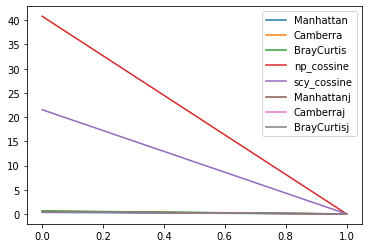

In [15]:
pd.DataFrame.from_dict(times, orient='columns').plot()

In [ ]:
pd.DataFrame.from_dict(times, orient='columns').drop(columns=['np_cossine','cossine_spy']).plot()

In [ ]:
pd.DataFrame.from_dict(times, orient='columns').to_csv('distis_results.csv')